## Load data

In [75]:
import numpy as np 
import pandas as pd 
from fbprophet import Prophet
import matplotlib.pyplot as plt
import math as math
import random

%matplotlib inline

In [2]:
#read the train set
train = pd.read_csv("train_1.csv")
keys = pd.read_csv("key_1.csv")

train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
print("Number of records: ", train.shape[0], "\n")

sample_w_null = train[train.isnull().any(axis=1)]
sample_full = train[train.notnull().all(axis=1)]

print("Number of records with NaN value: ", sample_w_null.shape[0], "\n")
print("Number of records without NaN value: ", sample_full.shape[0], "\n")

Number of records:  145063 

Number of records with NaN value:  27786 

Number of records without NaN value:  117277 



## Exploratory Data Analysis

/Users/MengqinGong_1/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/MengqinGong_1/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/MengqinGong_1/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/MengqinGong_1/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27231 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/MengqinGong_1/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24801 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/MengqinGong_1/opt/

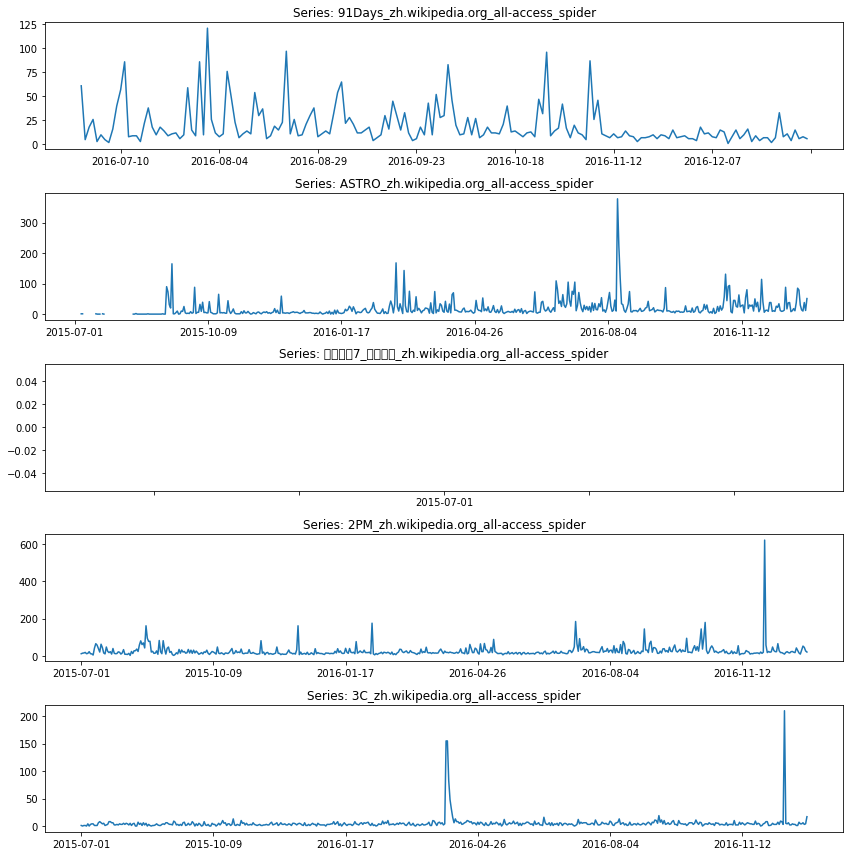

In [4]:
#plot sample time series

def plot_ts(df, row_num, start_col = 1, ax=None):
    if ax is None:
            fig = plt.figure(facecolor='w', figsize=(10, 6))
            ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
        
    series_title = df.iloc[row_num, 0]
    sample_series = df.iloc[row_num, start_col:]
    sample_series.plot(ax=ax)
    ax.set_title("Series: %s" % series_title)

fig, axs = plt.subplots(5,1,figsize=(12,12))
plot_ts(sample_w_null, 1, ax=axs[0])
plot_ts(sample_w_null, 2, ax=axs[1])
plot_ts(sample_w_null, 1008, ax=axs[2])
plot_ts(sample_full, 1, ax=axs[3])
plot_ts(sample_full, 2, ax=axs[4])

plt.tight_layout()


In [5]:
#fill NaN values with 0 
train = train.fillna(0)

In [6]:
#calculate sum/mean/median of each date
train_sum = train.sum(axis=0)

print(train_sum)

Page          2NE1_zh.wikipedia.org_all-access_spider2PM_zh....
2015-07-01                                          1.48672e+08
2015-07-02                                          1.49594e+08
2015-07-03                                          1.41164e+08
2015-07-04                                          1.45613e+08
                                    ...                        
2016-12-27                                          2.37248e+08
2016-12-28                                          2.30783e+08
2016-12-29                                          2.37887e+08
2016-12-30                                          2.07608e+08
2016-12-31                                          2.09322e+08
Length: 551, dtype: object


In [7]:
train_mean = train.mean(axis=0)
train_median = train.median(axis=0)

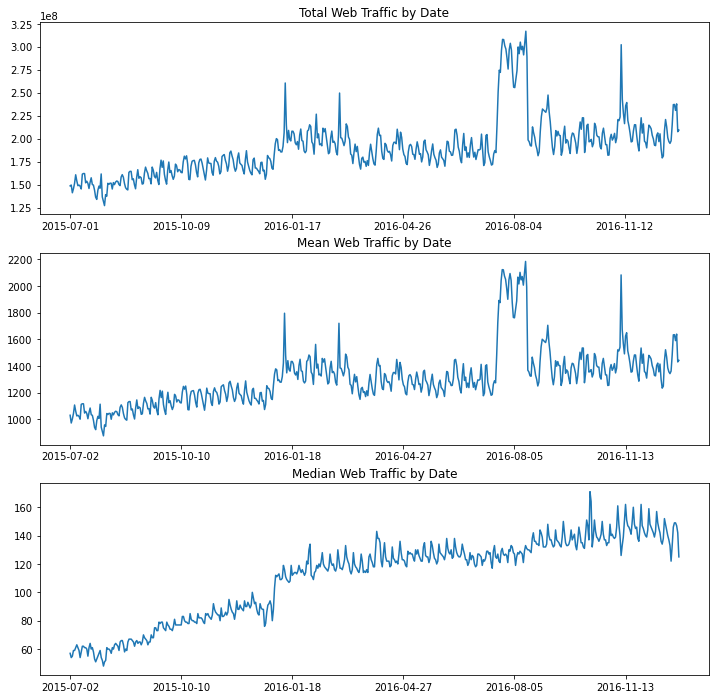

In [8]:
#plot sum/mean/median of web traffic

fig, axs = plt.subplots(3,1,figsize=(12,12))
train_sum[1:,].plot(title='Total Web Traffic by Date', ax=axs[0])
train_mean[1:,].plot(title='Mean Web Traffic by Date', ax=axs[1])
train_median[1:,].plot(title='Median Web Traffic by Date', ax=axs[2])

### Use median web traffic
Split train_median set to train set (499 days) and test set (50 days).

In [9]:
train_med = train_median[1:-50,]
test_med = train_median[-50:,]

print("Number of records in train set: ", train_med.shape[0], "\n")
print("Number of records in test set: ", test_med.shape[0], "\n")

Number of records in train set:  499 

Number of records in test set:  50 



## Forecast using FBProphet

In [10]:
from fbprophet import Prophet

train_med = pd.DataFrame(train_med).reset_index()
test_med = pd.DataFrame(test_med).reset_index()

In [11]:
train_med.columns = ["ds", "y"]
test_med.columns = ["ds", "y"]
train_med.head()

,ds,y
0,2015-07-02,57.0
1,2015-07-03,54.0
2,2015-07-04,55.0
3,2015-07-05,59.0
4,2015-07-06,59.0


In [12]:
#us_holidays = pd.read_csv("us-federal-holidays-2011-2020.csv")
#us_holidays['Date'] = pd.to_datetime(us_holidays['Date']).dt.strftime('%Y-%m-%d')
#us_holidays[['ds', 'holiday']] = us_holidays[['Date', 'Holiday']]
#us_holidays = us_holidays[['ds', 'holiday']]
#us_holidays.head()

In [13]:
m = Prophet(
            interval_width = 0.95,
            yearly_seasonality = True,
            weekly_seasonality = True,
            changepoint_prior_scale = 0.05)
m.add_country_holidays(country_name='US')
m.fit(train_med)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future = m.make_future_dataframe(periods=50)
future.tail()

,ds
544,2016-12-27
545,2016-12-28
546,2016-12-29
547,2016-12-30
548,2016-12-31


In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
544,2016-12-27,147.988483,139.532785,156.437403
545,2016-12-28,148.500230,139.972104,156.451370
546,2016-12-29,147.255583,139.177925,154.649351
547,2016-12-30,146.809797,139.285569,154.895532
548,2016-12-31,148.894940,141.242369,157.399683


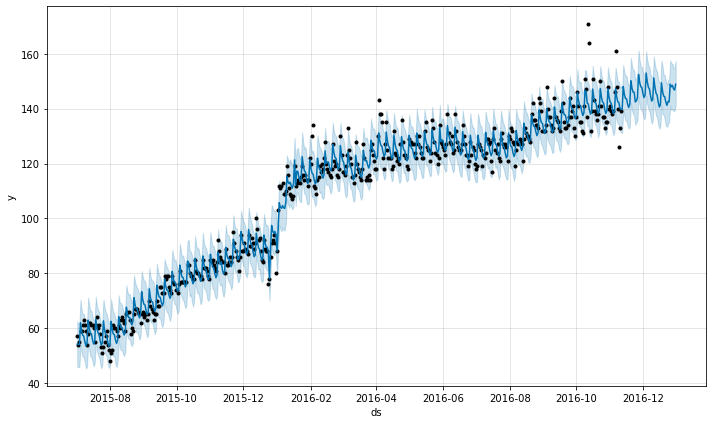

In [16]:
fig = m.plot(forecast)

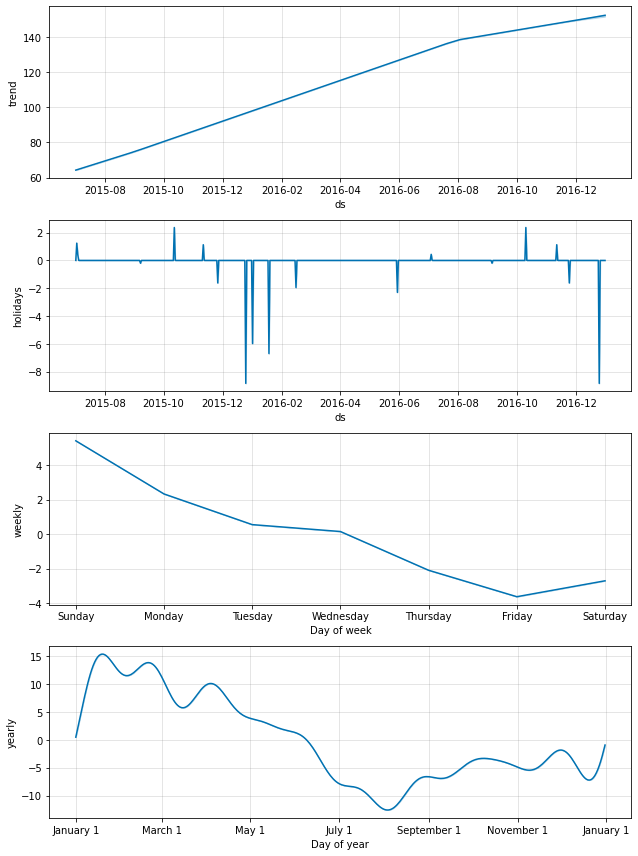

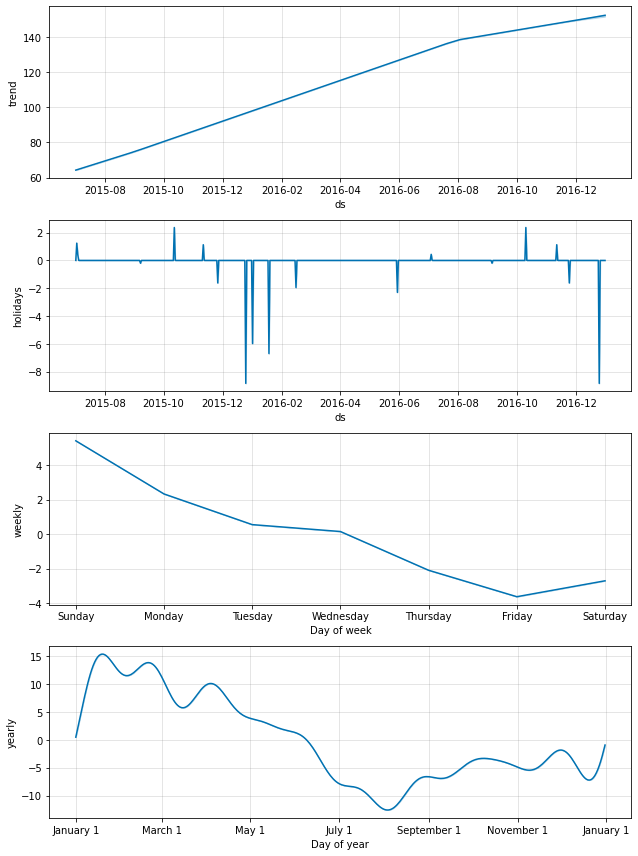

In [17]:
m.plot_components(forecast)

In [18]:
m2 = Prophet(
            interval_width = 0.95,
            yearly_seasonality = True,
            weekly_seasonality = True,
            changepoint_prior_scale = 2)
m2.add_country_holidays(country_name='US')
m2.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m2.fit(train_med)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
future2 = m2.make_future_dataframe(periods=50)
future2.tail()

,ds
544,2016-12-27
545,2016-12-28
546,2016-12-29
547,2016-12-30
548,2016-12-31


In [20]:
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
544,2016-12-27,136.127419,94.172027,175.640009
545,2016-12-28,136.150509,89.907139,174.618127
546,2016-12-29,133.773148,88.757729,175.129559
547,2016-12-30,131.735754,84.588129,174.090566
548,2016-12-31,132.548389,84.142094,174.100880


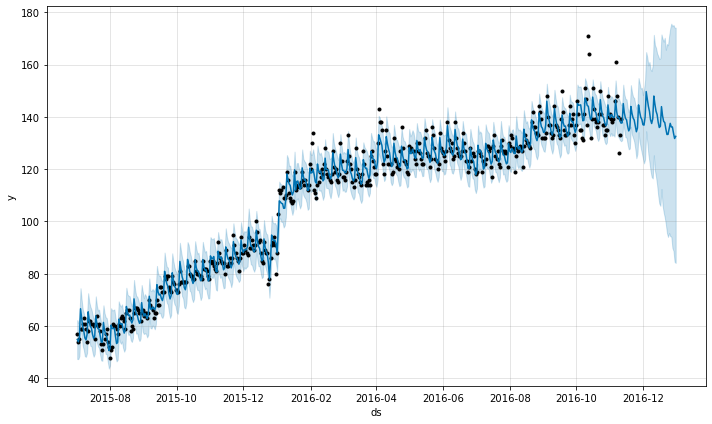

In [21]:
fig2 = m2.plot(forecast2)

In [62]:
test_med.ds = pd.to_datetime(test_med.ds)

In [64]:
predictions = pd.DataFrame(forecast2[-50:])
predictions.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
544,2016-12-27,155.448084,94.172027,175.640009,113.143052,191.956928,0.0,0.0,0.0,0.0,...,0.566040,0.566040,0.566040,-18.760924,-18.760924,-18.760924,0.0,0.0,0.0,136.127419
545,2016-12-28,155.600481,89.907139,174.618127,111.826396,193.359724,0.0,0.0,0.0,0.0,...,0.173670,0.173670,0.173670,-18.912473,-18.912473,-18.912473,0.0,0.0,0.0,136.150509
546,2016-12-29,155.752879,88.757729,175.129559,110.511091,194.832427,0.0,0.0,0.0,0.0,...,-2.115228,-2.115228,-2.115228,-18.988107,-18.988107,-18.988107,0.0,0.0,0.0,133.773148
547,2016-12-30,155.905276,84.588129,174.090566,109.211538,196.505118,0.0,0.0,0.0,0.0,...,-3.669132,-3.669132,-3.669132,-18.984559,-18.984559,-18.984559,0.0,0.0,0.0,131.735754
548,2016-12-31,156.057673,84.142094,174.100880,107.906568,198.177809,0.0,0.0,0.0,0.0,...,-2.718842,-2.718842,-2.718842,-18.899969,-18.899969,-18.899969,0.0,0.0,0.0,132.548389


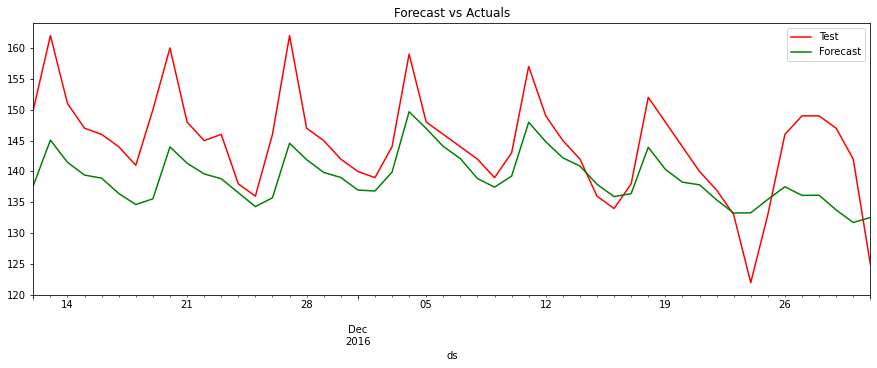

In [66]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test_med.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
predictions.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()


In [69]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [70]:
mape = mean_absolute_percentage_error(test_med['y'],predictions['yhat'])
print("MAPE",round(mape,4))

MAPE 4.3515


In [71]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [72]:
print("MAE yhat\t: {}\nMAE trend\t: {}\nMAE yhat_lower: {}\nMAE yhat_upper: {}".format(
    mean_absolute_error(test_med['y'].values,predictions['yhat']),
    mean_absolute_error(test_med['y'].values,predictions['trend']),
    mean_absolute_error(test_med['y'].values,predictions['yhat_lower']),
    mean_absolute_error(test_med['y'].values,predictions['yhat_upper'])))

MAE yhat	: 6.40274564725019
MAE trend	: 9.943017347970416
MAE yhat_lower: 27.14068408590203
MAE yhat_upper: 16.07148908346733


#### Hyperparameter Tuning

##### Here are some hyperparameters that can be tuned in Prophet model:
 - Holidays (added US holidays)
 - Changepoints: (n_changepoints,changepoint_prior_scale)
 - seasonality_mode
 - holiday_prior_scale
 - Seasonalities with fourier_order 
<br>
<br>
Let's try hyperparameter tuning using parametergrid. 
<br>
<br>
I am taking 5 parameters: n_changepoints, changepoint_prior_scale, seasonality_mode, holiday_prior_scale, monthly_seasonality fourier_order for tuning.

In [93]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.01,0.05,0.1],
              'holidays_prior_scale':[1,2,5],
              'n_changepoints' : [2,10,15],
              'fourier_order': [4,6,8,12]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 216


In [94]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(17)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         yearly_seasonality = True, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.add_seasonality(name='monthly', period=30.5, fourier_order=p['fourier_order'])
    train_model.fit(train_med)
    train_forecast = train_model.make_future_dataframe(periods=50,include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test = train_forecast[['ds','yhat']]
    MAPE = mean_absolute_percentage_error(test_med['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.403459443163292
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.690336800510093
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.096254280315009
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.148152677973295
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.410765450794224
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.167437488110637
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.403046034315561
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.690009513744972
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.168041069298343
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.3273437036272036
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.446019052671116
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.161806636774814
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.417979619426423
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.705739580207141
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.167191502773675
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.315998552372837
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.421788399609415
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.170812058711804
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.350319133033544
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.6764104011282575
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.062327825122125
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.181168785794148
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.065199165196219
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.19222163917219
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.365608456995069
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.6660785660367905
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.123841285482275
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.190448203341094
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.1774627516108165
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.00803680378729
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.374796679931014
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.67492212384933
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.146507674898822
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.128233778933112
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.856557888134912
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.993214416185076
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.352922685161901
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.6706723774482946
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.2659520808701075
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.0845763622349995
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.263642840364953
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.961438429911479
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.330239512127025
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.6569182749851175
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.290070417722728
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.062860944606893
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.249739813066056
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.2761071562588935
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.358584510088165
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.658154054390243
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.32155687919711
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.052707667693011
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.266254328359209
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.954892345060868
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.391555236941273
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.670591295662275
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.112488142141216
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.257017366174128
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.392428352087945
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.287198471529036
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.3911972760247036
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.6821576916552745
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.453840179381017
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.100764293333738
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.878342453532609
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.293021659298468
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.411208146659246
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.696612173925471
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.279927040435159
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.692048073071757
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.133231904283657
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 5.279113282677572
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8439536286912586
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.181792669319927
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.6744922803596296
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.2571803493105165
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.865246651091628
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1401363614598417
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8365568064356146
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1881939523874436
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.6558419373282978
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1256213219731386
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.754862933984768
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.166372697847717
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8185843326753894
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.181990410807563
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.672140521340469
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.204460711397239
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.858271374978482
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1001114052491174
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.810793613757351
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1313407269288684
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.6346516526556516
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1624250388531854
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.9545998215763807
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1123702601183516
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8104560336148703
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.132978651794432
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.6092767042511733
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.084485587340905
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.69645252818424
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.101846631589466
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8103657561785207
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.131809144456996
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.594297196545647
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1169100035476083
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.6856429457580795
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0654485471386543
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8012033999199293
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.167497797868399
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.639560752709179
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.158522933997244
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.90983986459785
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1334402908743475
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8015984652204877
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.167644095653445
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.6233021692914047
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.12940168124302
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.7301774055835666
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1301803004465194
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8153353674600377
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1681206415467478
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.633650589042445
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1779750244469525
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.682138968322558
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.12971368141417
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8321325823643795
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1981461410874705
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.726412568005026
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.2301864012486226
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.7621449019083673
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.156413142897821
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8318841003081676
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1965430087416062
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.731629635517944
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.2276008638710745
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8439607304288663
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1836682363459503
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8318286603881004
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1973218960933023
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.7297917895531487
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.2377451219067828
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.8081022415077106
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.167011978287849
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.176114137985
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1024430260669593
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.7693110379936905
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.039102364418226
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.1342482068461255
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0742638379778118
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1717269137659008
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1037938846474145
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.5303666385813974
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.035683167246111
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.220399315240643
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0616925513216144
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.182649666527668
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1035313848460184
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.8773964646596903
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0407277093359397
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.298922763824998
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0634195432962055
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1280334083248587
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0638872743992165
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.827073571700258
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.9686052558364606
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.146301627672609
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.9710563343922995
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.151966054888951
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.06709868807394
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.7782915540065964
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.9722774671674537
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.401454346752828
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.966646414229149
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1245672419263983
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0572841409089047
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.727398865506536
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.9658924735112704
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.168909087009586
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0013923151088004
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1447442080479364
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.109336544689261
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.8683802407504477
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0086972750381373
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.406666006912073
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.9922929152153506
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.125762485033081
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.109893747941123
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.7657583466001205
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0133480756406956
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.272695947011229
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.995261225913418
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0980163600852624
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.111893892974112
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.8297661827256557
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0135333856334805
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.293694100081985
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.991360108317084
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.150498169318027
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1325577526683253
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.837951794874688
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.005570438663315
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.194560819633654
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0117223548452636
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1698017646876036
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1306852394413323
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.7527380506510255
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.014799388065096
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.196376522178612
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.012761849161096
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1109227795994685
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1319787596408446
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.709239070970147
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0223273406230016
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.2652295556849005
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 3.0053031681622313


In [95]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,2.594297,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
1,2.609277,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
2,2.623302,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
3,2.633651,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
4,2.634652,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."


In [96]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.05,
 'fourier_order': 6,
 'holidays_prior_scale': 5,
 'n_changepoints': 10,
 'seasonality_mode': 'multiplicative'}

Select the model which has the least MAPE to train the final model and make predictions.

In [97]:
final_model = Prophet(
                      changepoint_prior_scale= 0.05,
                      holidays_prior_scale = 5,
                      n_changepoints = 10,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.add_seasonality(name='monthly', period=30.5, fourier_order=6)


final_model.fit(train_med)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [98]:
future = final_model.make_future_dataframe(periods=50)
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
544,2016-12-27,143.583063,135.958980,150.425805
545,2016-12-28,145.714121,138.266548,152.885257
546,2016-12-29,143.556343,136.091120,150.643478
547,2016-12-30,140.880262,133.156881,148.218974
548,2016-12-31,143.421240,135.714372,150.846238


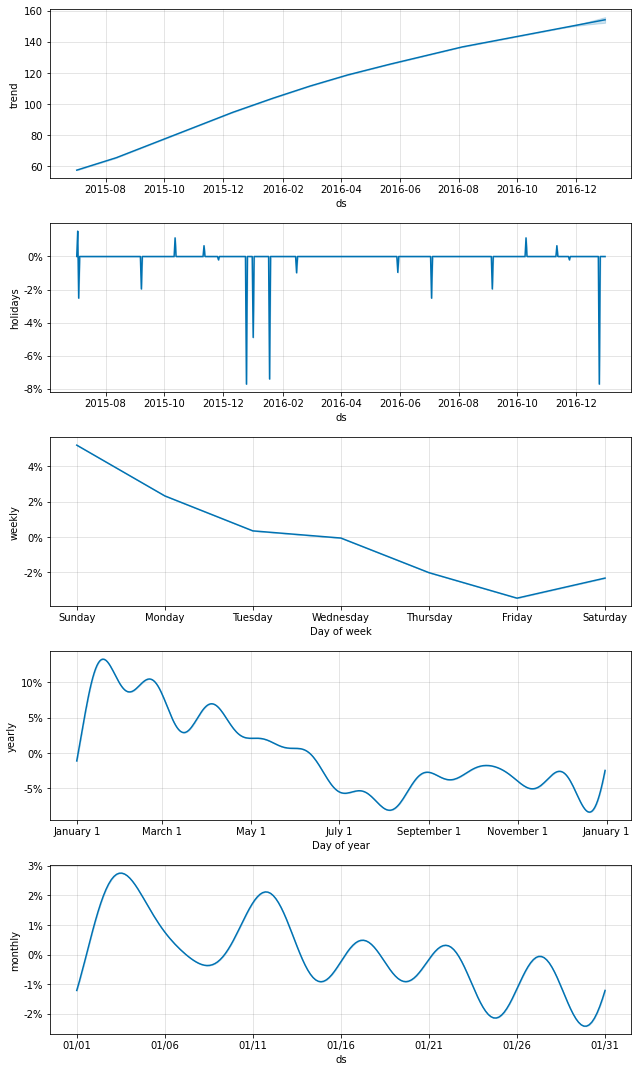

In [99]:
fig = final_model.plot_components(forecast)

In [100]:
final_predictions = pd.DataFrame(forecast[-50:])
final_predictions.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
544,2016-12-27,153.624718,135.958980,150.425805,151.914212,155.145979,0.0,0.0,0.0,0.0,...,0.003446,0.003446,0.003446,-0.058370,-0.058370,-0.058370,0.0,0.0,0.0,143.583063
545,2016-12-28,153.742301,138.266548,152.885257,151.974796,155.317280,0.0,0.0,0.0,0.0,...,-0.000603,-0.000603,-0.000603,-0.050578,-0.050578,-0.050578,0.0,0.0,0.0,145.714121
546,2016-12-29,153.859885,136.091120,150.643478,152.032276,155.483378,0.0,0.0,0.0,0.0,...,-0.020125,-0.020125,-0.020125,-0.041871,-0.041871,-0.041871,0.0,0.0,0.0,143.556343
547,2016-12-30,153.977468,133.156881,148.218974,152.095091,155.639778,0.0,0.0,0.0,0.0,...,-0.034513,-0.034513,-0.034513,-0.032339,-0.032339,-0.032339,0.0,0.0,0.0,140.880262
548,2016-12-31,154.095052,135.714372,150.846238,152.154826,155.796177,0.0,0.0,0.0,0.0,...,-0.023186,-0.023186,-0.023186,-0.022087,-0.022087,-0.022087,0.0,0.0,0.0,143.421240


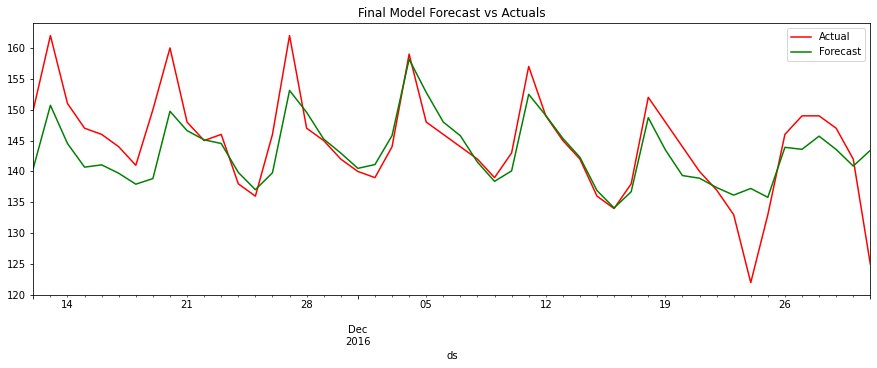

In [101]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test_med.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
final_predictions.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Final Model Forecast vs Actuals')
plt.show()

In [103]:
final_mape = mean_absolute_percentage_error(test_med['y'],final_predictions['yhat'])
print("MAPE",round(final_mape,4))

MAPE 2.5943


In [104]:
print("MAE yhat\t: {}\nMAE trend\t: {}\nMAE yhat_lower: {}\nMAE yhat_upper: {}".format(
    mean_absolute_error(test_med['y'].values,final_predictions['yhat']),
    mean_absolute_error(test_med['y'].values,final_predictions['trend']),
    mean_absolute_error(test_med['y'].values,final_predictions['yhat_lower']),
    mean_absolute_error(test_med['y'].values,final_predictions['yhat_upper'])))

MAE yhat	: 3.7256935401145888
MAE trend	: 9.032466914063807
MAE yhat_lower: 9.468466496005284
MAE yhat_upper: 6.656685342789758
